# MultiModal

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [0]:
!tar -xvf /content/gdrive/My\ Drive/MultiModal/data/sunrgbd_lite.tar.gz

# Utils to load and work with RGB-D data

In [0]:
import torch
import os
import sys
sys.path.append('/content/gdrive/My Drive/MultiModal')
import RGBDutils

In [0]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import itertools

# Baseline, Monomodal
Let's see how RGBD and Depth monomodal learning work alone

## Monomodal datasets


In [0]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Path to the dataset
data_dir = 'sunrgbd_lite'

# Preparing dataset and dataloaders
partitions = ['train', 'val', 'test']
rgb_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x, 'rgb'),
                                          data_transforms[x])
                  for x in partitions}

hha_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x, 'hha'),
                                          data_transforms[x])
                  for x in partitions}

rgb_dataloaders = {x: torch.utils.data.DataLoader(rgb_datasets[x], batch_size=4,
                                                shuffle=True, num_workers=4)
                  for x in partitions}

hha_dataloaders = {x: torch.utils.data.DataLoader(hha_datasets[x], batch_size=4,
                                                shuffle=True, num_workers=4)
                  for x in partitions}
rgb_dataset_sizes = {x: len(rgb_datasets[x]) for x in partitions}
hha_dataset_sizes = {x: len(hha_datasets[x]) for x in partitions}

class_names = rgb_datasets['train'].classes

cuda = torch.cuda.is_available()

Let's visualize some images

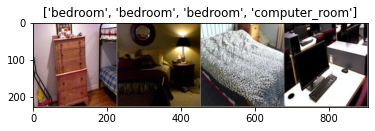

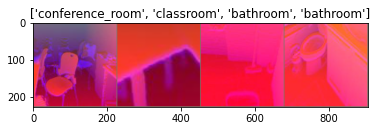

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
rgb_images, rgb_classes = next(iter(rgb_dataloaders['train']))
hha_images, hha_classes = next(iter(hha_dataloaders['train']))
rgb_images, rgb_classes = rgb_images[0:4], rgb_classes[0:4]
hha_images, hha_classes = hha_images[0:4], hha_classes[0:4]

# Make a grid from batch
rgb_out = torchvision.utils.make_grid(rgb_images)
hha_out = torchvision.utils.make_grid(hha_images)

imshow(rgb_out, title=[class_names[x] for x in rgb_classes])
imshow(hha_out, title=[class_names[x] for x in hha_classes])

## Monomodal training utilities

Breaking it into smaller pieces helps us be more familiar with the actual implementation

In [0]:
def monomodal_train_epoch(dataloaders, epoch, model, scheduler, optimizer, criterion, best_model_wts, best_acc):
  # Each epoch has a training and validation phase
  for phase in ['train', 'val']:
    print('Phase %s' % phase)
    if phase == 'train':
      if scheduler != None:
        scheduler.step()
        model.train(True)  # Set model to training mode
      else:
        model.train(False)  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0.0

    # Iterate over data.
    for inputs, labels in dataloaders[phase]:
      if cuda:
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
      else:
        inputs, labels = Variable(inputs), Variable(labels)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      outputs = model(inputs)
      _, preds = torch.max(outputs.data, 1)
      loss = criterion(outputs, labels)

      # backward + optimize only if in training phase
      if phase == 'train':
        loss.backward()
        optimizer.step()

      # statistics
      # running_loss += loss.data[0] * inputs.size(0) # Pytorch 0.4
      running_loss += loss.data.item() * inputs.size(0) # Pytorch 1
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / rgb_dataset_sizes[phase]
    epoch_acc = running_corrects / rgb_dataset_sizes[phase]

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    # deep copy the model
    if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

  print()
  return best_model_wts, best_acc

def monomodal_train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        best_model_wts, best_acc = monomodal_train_epoch(dataloaders, epoch, model, scheduler, optimizer, criterion, best_model_wts, best_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Evaluation model utility

In [0]:
def evaluate_monomodal_model(dataloaders, model, partition, criterion):
    since = time.time()

    model.train(False)  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0.0

    # Iterate over data.
    for data in dataloaders[partition]:
        # get the inputs
        inputs, labels = data
        # wrap them in Variable
        if cuda:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # statistics
        # running_loss += loss.data[0] * inputs.size(0) # Pytorch 0.4
        running_loss += loss.data.item() * inputs.size(0) # Pytorch 1
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / rgb_dataset_sizes[partition]
    test_acc = running_corrects / rgb_dataset_sizes[partition]
    
    print()

    time_elapsed = time.time() - since
    print('Tested in {:.0f}m {:.0f}s Loss: {:.4f} Acc: {:.4f}'.format(
        time_elapsed // 60, time_elapsed % 60, test_loss, test_acc))

    return test_acc, test_loss

In [0]:
# Train For
def trainAndEvaluateMonoModal(dalaloaders, initialize_model):
  model, criterion, optimizer = initialize_model()
  model = monomodal_train_model(dalaloaders, model, criterion, optimizer, None, num_epochs=25)
    
  # Evaluate
  train_acc, _ = evaluate_monomodal_model(dalaloaders, model, 'train', criterion)
  val_acc, _ = evaluate_monomodal_model(dalaloaders, model, 'val', criterion)
  test_acc, _ = evaluate_monomodal_model(dalaloaders, model, 'test', criterion)
  print('Accuracy. Train: %1.2f%% val: %1.2f%% test: %1.2f%%' % 
        (train_acc*100, val_acc*100, test_acc*100))
  return train_acc, val_acc, test_acc

In [0]:
def initialize_model_monomodal():
  model = models.alexnet(pretrained=True)

  for param in model.parameters(): # Freeze all parameters by default
    param.requires_grad = False
    
  num_classes = len(class_names)
  c = model.classifier
  num_ftrs = c[6].in_features
  model.classifier = nn.Sequential(c[0],c[1],c[2],c[3],c[4],c[5],nn.Linear(num_ftrs, num_classes))

  if cuda:
    model = model.cuda()

  criterion = nn.CrossEntropyLoss()

  learning_rate =0.001
  perlayer_optim = [
    {'params': model.features[0].parameters(), 'lr': 0.00}, # conv1
    {'params': model.features[3].parameters(), 'lr': 0.00}, # conv2
    {'params': model.features[6].parameters(), 'lr': 0.00}, # conv3
    {'params': model.features[8].parameters(), 'lr': 0.00}, # conv4
    {'params': model.features[10].parameters(), 'lr': 0.00}, # conv5
    {'params': model.classifier[1].parameters(), 'lr': 0.000}, # fc6
    {'params': model.classifier[4].parameters(), 'lr': 0.000}, # fc7
    {'params': model.classifier[6].parameters(), 'lr': 0.001} # fc8
  ]
  for param in itertools.chain(model.features[0].parameters(),model.features[3].parameters(),
                             model.features[6].parameters(),model.features[8].parameters(),
                             model.features[10].parameters(),model.classifier[1].parameters(),
                             model.classifier[4].parameters(),model.classifier[6].parameters()):
    param.requires_grad = True
    
  optimizer = torch.optim.Adam(perlayer_optim, lr=learning_rate)

  return model, criterion, optimizer


## Train And evaluate RGB 5 runs


In [0]:
import numpy as np
results = list(map(lambda x: trainAndEvaluateMonoModal(rgb_dataloaders, initialize_model_monomodal), range(0, 5)))
train_accs = list(map(lambda x: x[0], results))
val_accs = list(map(lambda x: x[1], results))
test_accs = list(map(lambda x: x[2], results))

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Epoch 0/24
----------
Phase train
train Loss: 0.8945 Acc: 0.6940
Phase val
val Loss: 0.8195 Acc: 0.7189

Epoch 1/24
----------
Phase train
train Loss: 0.5077 Acc: 0.8215
Phase val
val Loss: 0.7621 Acc: 0.7442

Epoch 2/24
----------
Phase train
train Loss: 0.4827 Acc: 0.8403
Phase val
val Loss: 0.7374 Acc: 0.7638

Epoch 3/24
----------
Phase train
train Loss: 0.3418 Acc: 0.8711
Phase val
val Loss: 0.7115 Acc: 0.7834

Epoch 4/24
----------
Phase train
train Loss: 0.3379 Acc: 0.8765
Phase val
val Loss: 0.8985 Acc: 0.7569

Epoch 5/24
----------
Phase train
train Loss: 0.3445 Acc: 0.8658
Phase val
val Loss: 0.9817 Acc: 0.7373

Epoch 6/24
----------
Phase train
train Loss: 0.3544 Acc: 0.8805
Phase val
val Loss: 0.7893 Acc: 0.7719

Epoch 7/24
----------
Phase train
train Loss: 0.3094 Acc: 0.8899
Phase val
val Loss: 0.8461 Acc: 0.7903

Epoch 8/24
----------
Phase train
train Loss: 0.2828 Acc: 0.8980
Phase val
val Loss: 1.0417 Acc: 0.7523

Epoch 9/24
----------
Phase train
train Loss: 0.2853 A

In [0]:
print('Mean training RGB accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), train_accs)))))
print('StDev training RGB accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), train_accs)))))

print('Mean validation RGB accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), val_accs)))))
print('StDev validation RGB accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), val_accs)))))

print('Mean test RGB accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), test_accs)))))
print('StDev test RGB accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), test_accs)))))

Mean training RGB accuracy 88.9932930469513%
StDev training RGB accuracy 0.9182627312839031%
Mean validation RGB accuracy 79.23963665962219%
StDev validation RGB accuracy 0.4456020426005125%
Mean test RGB accuracy 71.92186117172241%
StDev test RGB accuracy 1.7573904246091843%


## Train And evaluate HHA 5 runs


In [0]:
import numpy as np
results = list(map(lambda x: trainAndEvaluateMonoModal(hha_dataloaders, initialize_model_monomodal), range(0, 5)))
train_accs = list(map(lambda x: x[0], results))
val_accs = list(map(lambda x: x[1], results))
test_accs = list(map(lambda x: x[2], results))

Epoch 0/24
----------
Phase train
train Loss: 1.1891 Acc: 0.5342
Phase val
val Loss: 1.2587 Acc: 0.5599

Epoch 1/24
----------
Phase train
train Loss: 0.9373 Acc: 0.6564
Phase val
val Loss: 1.5276 Acc: 0.4712

Epoch 2/24
----------
Phase train
train Loss: 0.8997 Acc: 0.6604
Phase val
val Loss: 1.3357 Acc: 0.5230

Epoch 3/24
----------
Phase train
train Loss: 0.8182 Acc: 0.6966
Phase val
val Loss: 1.4938 Acc: 0.5749

Epoch 4/24
----------
Phase train
train Loss: 0.7601 Acc: 0.7074
Phase val
val Loss: 1.4682 Acc: 0.5415

Epoch 5/24
----------
Phase train
train Loss: 0.6959 Acc: 0.7570
Phase val
val Loss: 1.3479 Acc: 0.6037

Epoch 6/24
----------
Phase train
train Loss: 0.7779 Acc: 0.7208
Phase val
val Loss: 1.6109 Acc: 0.6486

Epoch 7/24
----------
Phase train
train Loss: 0.7403 Acc: 0.7369
Phase val
val Loss: 1.7938 Acc: 0.5541

Epoch 8/24
----------
Phase train
train Loss: 0.7520 Acc: 0.7396
Phase val
val Loss: 1.6647 Acc: 0.6002

Epoch 9/24
----------
Phase train
train Loss: 0.5938 Ac

In [0]:
print('Mean training HHA accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), train_accs)))))
print('StDev training HHA accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), train_accs)))))

print('Mean validation HHA accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), val_accs)))))
print('StDev validation HHA accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), val_accs)))))

print('Mean test HHA accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), test_accs)))))
print('StDev test HHA accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), test_accs)))))

Mean training HHA accuracy 77.23489999771118%
StDev training HHA accuracy 3.367602452635765%
Mean validation HHA accuracy 66.19815230369568%
StDev validation HHA accuracy 1.254861243069172%
Mean test HHA accuracy 61.37365698814392%
StDev test HHA accuracy 1.644117571413517%


# Baseline, multimodal

## Multimodal datasets

In [0]:
# Data augmentation and normalization for training
RGB_AVG = [0.485, 0.456, 0.406] # Default ImageNet ILSRVC2012
RGB_STD = [0.229, 0.224, 0.225] # Default ImageNet ILSRVC2012
DEPTH_AVG = [0.485, 0.456, 0.406] # Default ImageNet ILSRVC2012
DEPTH_STD = [0.229, 0.224, 0.225] # Default ImageNet ILSRVC2012
data_transforms = {
    'train': RGBDutils.Compose([
        RGBDutils.RandomResizedCrop(227),
        RGBDutils.RandomHorizontalFlip(),
        RGBDutils.ToTensor(),
        RGBDutils.Normalize(RGB_AVG, RGB_STD, DEPTH_AVG, DEPTH_STD)
    ]),
    'val': RGBDutils.Compose([
        RGBDutils.Resize(256),
        RGBDutils.CenterCrop(227),
        RGBDutils.ToTensor(),
        RGBDutils.Normalize(RGB_AVG, RGB_STD, DEPTH_AVG, DEPTH_STD)
    ]),
    'test': RGBDutils.Compose([
        RGBDutils.Resize(256),
        RGBDutils.CenterCrop(227),
        RGBDutils.ToTensor(),
        RGBDutils.Normalize(RGB_AVG, RGB_STD, DEPTH_AVG, DEPTH_STD)
    ]),
}

# Path to the dataset
# data_dir = '/home/mcv/datasets/sunrgbd_lite'
data_dir = 'sunrgbd_lite'

# Preparing dataset and dataloaders
partitions = ['train', 'val', 'test']
multimodal_datasets = {x: RGBDutils.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                    for x in partitions}

multimodal_dataloaders = {x: torch.utils.data.DataLoader(multimodal_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
                    for x in partitions}

dataset_sizes = {x: len(multimodal_datasets[x]) for x in partitions}
class_names = multimodal_datasets['train'].classes

cuda = torch.cuda.is_available()

Let's visualize some images

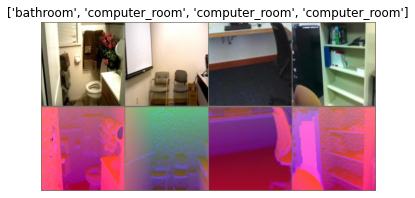

In [0]:
# Get a batch of training data and visualize the first four pairs
inputsRGB, inputsDepth, classes = next(iter(multimodal_dataloaders['train']))
inputsRGB, inputsDepth, classes = inputsRGB[0:4], inputsDepth[0:4], classes[0:4]

# Make a grid from batch
outRGB = torchvision.utils.make_grid(inputsRGB)
outDepth = torchvision.utils.make_grid(inputsDepth)

RGBDutils.imshow(outRGB, outDepth, title=[class_names[x] for x in classes],concat_vert=True)

## Training multimodal utility

In [0]:
def multimodal_train_epoch(dataloaders, epoch, model, scheduler, optimizer, criterion, best_model_wts, best_acc):
  # Each epoch has a training and validation phase
  for phase in ['train', 'val']:
    print('Phase %s' % phase)
    if phase == 'train':
      if scheduler != None:
        scheduler.step()
        model.train(True)  # Set model to training mode
      else:
        model.train(False)  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0.0

    # Iterate over data.
    for inputs_rgb, inputs_hha, labels in dataloaders[phase]:
      if cuda:
        inputs_rgb = Variable(inputs_rgb.cuda())
        inputs_hha = Variable(inputs_hha.cuda())
        labels = Variable(labels.cuda())
      else:
        inputs_rgb, inputs_hha, labels = Variable(inputs_hha), Variable(inputs_hha), Variable(labels)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      outputs = model((inputs_rgb, inputs_hha))
      _, preds = torch.max(outputs.data, 1)
      loss = criterion(outputs, labels)

      # backward + optimize only if in training phase
      if phase == 'train':
        loss.backward()
        optimizer.step()

      # statistics
      # running_loss += loss.data[0] * inputs.size(0) # Pytorch 0.4
      running_loss += loss.data.item() * inputs_rgb.size(0) # Pytorch 1
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects / dataset_sizes[phase]

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    # deep copy the model
    if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

  print()
  return best_model_wts, best_acc

def multimodal_train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        best_model_wts, best_acc = multimodal_train_epoch(dataloaders, epoch, model, scheduler, optimizer, criterion, best_model_wts, best_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Evaluation multimodal utility

In [0]:
def evaluate_multimodal_model(dataloaders, model, partition, criterion):
    since = time.time()

    model.train(False)  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0.0

    # Iterate over data.
    for data in dataloaders[partition]:
        # get the inputs
        inputs_rgb, inputs_hha, labels = data
        # wrap them in Variable
        if cuda:
            inputs_rgb = Variable(inputs_rgb.cuda())
            inputs_hha = Variable(inputs_hha.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs_rgb, inputs_hha, labels = Variable(inputs_hha), Variable(inputs_hha), Variable(labels)

        # forward
        outputs = model((inputs_rgb, inputs_hha))
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # statistics
        # running_loss += loss.data[0] * inputs_rgb.size(0) # Pytorch 0.4
        running_loss += loss.data.item() * inputs_rgb.size(0) # Pytorch 1
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / dataset_sizes[partition]
    test_acc = running_corrects / dataset_sizes[partition]
    
    print()

    time_elapsed = time.time() - since
    print('Tested in {:.0f}m {:.0f}s Loss: {:.4f} Acc: {:.4f}'.format(
        time_elapsed // 60, time_elapsed % 60, test_loss, test_acc))

    return test_acc, test_loss

In [0]:
# Train For
def trainAndEvaluateMultiModal(dalaloaders, initialize_model, num_epochs=25):
  model, criterion, optimizer = initialize_model()
  model = multimodal_train_model(dalaloaders, model, criterion, optimizer, None, num_epochs=num_epochs)
    
  # Evaluate
  train_acc, _ = evaluate_multimodal_model(dalaloaders, model, 'train', criterion)
  val_acc, _ = evaluate_multimodal_model(dalaloaders, model, 'val', criterion)
  test_acc, _ = evaluate_multimodal_model(dalaloaders, model, 'test', criterion)
  print('Accuracy. Train: %1.2f%% val: %1.2f%% test: %1.2f%%' % 
        (train_acc*100, val_acc*100, test_acc*100))
  return train_acc, val_acc, test_acc

## Class to implement MultiModal network with two branches

In [0]:
# In PyTorch every network is implementd as a nn.Module
class RGBDnet(nn.Module):
    # The parameters are initialized in __init__(self, ...)
    def __init__(self, rgb_branch, hha_branch, num_classes):
        super(RGBDnet, self).__init__()
        
        # RGB branch
        model_rgb = rgb_branch
        self.rgb_convs = model_rgb.features
        c = model_rgb.classifier
        self.rgb_fcs = nn.Sequential(c[0],c[1],c[2],c[3],c[4],c[5])
        num_ftrs_rgb = c[4].out_features

        # HHA branch
        model_hha = hha_branch
        self.hha_convs = model_hha.features
        c = model_hha.classifier
        self.hha_fcs = nn.Sequential(c[0],c[1],c[2],c[3],c[4],c[5])
        f = model_hha.features
        c = model_hha.classifier
        num_ftrs_hha = c[4].out_features

        # Classifier
        self.classifier = nn.Linear(num_ftrs_rgb+num_ftrs_hha, num_classes)

    # The data flow is defined in forward. No need to specify backward operations (PyTorch takes care of them)
    def forward(self, x):
        x_rgb = self.rgb_convs(x[0])
        x_rgb = x_rgb.view(x_rgb.size(0), 256 * 6 * 6)
        x_hha = self.hha_convs(x[1])
        x_hha = x_hha.view(x_hha.size(0), 256 * 6 * 6)
        x_rgb = self.rgb_fcs(x_rgb)
        x_hha = self.hha_fcs(x_hha)
        x = torch.cat((x_rgb, x_hha), 1)
        x = self.classifier(x)
        return x

In [0]:
import torchvision.models
def initialize_model_rgbd():
  # Instantiate the model
  num_classes = len(class_names)
  model = RGBDnet(rgb_branch=models.alexnet(pretrained=True),
                hha_branch=models.alexnet(pretrained=True), 
                num_classes=num_classes)

  # Here we define the learning rate
  for param in model.parameters(): # Freeze all parameters by default
    param.requires_grad = False

  if cuda:
    model = model.cuda()

  criterion = nn.CrossEntropyLoss()

  learning_rate = 0.001
    
  perlayer_optim = [
    {'params': model.rgb_convs[0].parameters(), 'lr': 0.00}, # conv1 RGB
    {'params': model.rgb_convs[3].parameters(), 'lr': 0.00}, # conv2 RGB
    {'params': model.rgb_convs[6].parameters(), 'lr': 0.00}, # conv3 RGB
    {'params': model.rgb_convs[8].parameters(), 'lr': 0.00}, # conv4 RGB
    {'params': model.rgb_convs[10].parameters(), 'lr': 0.00}, # conv5 RGB
    {'params': model.rgb_fcs[1].parameters(), 'lr': 0.00}, # fc6 RGB
    {'params': model.rgb_fcs[4].parameters(), 'lr': 0.00}, # fc7 RGB
    {'params': model.hha_convs[0].parameters(), 'lr': 0.00}, # conv1 HHA
    {'params': model.hha_convs[3].parameters(), 'lr': 0.00}, # conv2 HHA
    {'params': model.hha_convs[6].parameters(), 'lr': 0.00}, # conv3 HHA
    {'params': model.hha_convs[8].parameters(), 'lr': 0.00}, # conv4 HHA
    {'params': model.hha_convs[10].parameters(), 'lr': 0.00}, # conv5 HHA
    {'params': model.hha_fcs[1].parameters(), 'lr': 0.00}, # fc6 HHA
    {'params': model.hha_fcs[4].parameters(), 'lr': 0.00}, # fc7 HHA
    {'params': model.classifier.parameters(), 'lr': 0.001} # fc8
  ]
  for param in itertools.chain(model.rgb_convs[0].parameters(),model.rgb_convs[3].parameters(),
                             model.rgb_convs[6].parameters(),model.rgb_convs[8].parameters(),
                             model.rgb_convs[10].parameters(),model.rgb_fcs[1].parameters(),
                             model.rgb_fcs[4].parameters(),
                             model.hha_convs[0].parameters(),model.hha_convs[3].parameters(),
                             model.hha_convs[6].parameters(),model.hha_convs[8].parameters(),
                             model.hha_convs[10].parameters(),model.hha_fcs[1].parameters(),
                             model.hha_fcs[4].parameters(),
                             model.classifier.parameters()):
    param.requires_grad = True
    
    
  optimizer = torch.optim.Adam(perlayer_optim, lr=learning_rate)

  return model, criterion, optimizer

## Train And evaluate RGB-D 5 runs

In [0]:
import numpy as np
results = list(map(lambda x: trainAndEvaluateMultiModal(multimodal_dataloaders, initialize_model_rgbd), range(0, 5)))
train_accs = list(map(lambda x: x[0], results))
val_accs = list(map(lambda x: x[1], results))
test_accs = list(map(lambda x: x[2], results))

Epoch 0/24
----------
Phase train
train Loss: 0.9605 Acc: 0.6201
Phase val
val Loss: 0.7204 Acc: 0.7350

Epoch 1/24
----------
Phase train
train Loss: 0.4970 Acc: 0.8054
Phase val
val Loss: 0.6755 Acc: 0.7650

Epoch 2/24
----------
Phase train
train Loss: 0.4234 Acc: 0.8550
Phase val
val Loss: 0.5849 Acc: 0.8088

Epoch 3/24
----------
Phase train
train Loss: 0.3332 Acc: 0.8792
Phase val
val Loss: 0.6695 Acc: 0.7800

Epoch 4/24
----------
Phase train
train Loss: 0.3575 Acc: 0.8644
Phase val
val Loss: 0.6342 Acc: 0.7800

Epoch 5/24
----------
Phase train
train Loss: 0.2948 Acc: 0.9060
Phase val
val Loss: 0.5879 Acc: 0.7984

Epoch 6/24
----------
Phase train
train Loss: 0.2323 Acc: 0.9262
Phase val
val Loss: 0.6534 Acc: 0.7730

Epoch 7/24
----------
Phase train
train Loss: 0.2235 Acc: 0.9221
Phase val
val Loss: 0.5946 Acc: 0.8088

Epoch 8/24
----------
Phase train
train Loss: 0.2354 Acc: 0.9208
Phase val
val Loss: 0.6223 Acc: 0.7892

Epoch 9/24
----------
Phase train
train Loss: 0.2093 Ac

In [0]:
print('Mean training RGB-D accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), train_accs)))))
print('StDev training RGB-D accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), train_accs)))))

print('Mean validation RGB-D accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), val_accs)))))
print('StDev validation RGB-D accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), val_accs)))))

print('Mean test RGB-D accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), test_accs)))))
print('StDev test RGB-D accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), test_accs)))))

Mean training RGB-D accuracy 91.91946983337402%
StDev training RGB-D accuracy 3.633992001414299%
Mean validation RGB-D accuracy 80.94469904899597%
StDev validation RGB-D accuracy 0.5764981266111135%
Mean test RGB-D accuracy 75.79079866409302%
StDev test RGB-D accuracy 0.6756109185516834%


# Comparison Monomodal vs MultiModal performance


Experiment Name | Train Accuracy (Avg/StdDev)| Val Accuracy (Avg/StdDev)| Test accuracy (Avg/StdDev)|
--- | --- | --- | ---
RGB | 88.99 % / 0.92 % | 79.24 % / 0.44 % | 71.92 % / 1.76 %
HHA |  77.23 % / 3.36 % | 66.20 % / 1.25 % | 61.37 % / 1.64 %
RGB-D | 91.92 % / 3.64 % | 80.94% / 0.58 % | 75.79 % / 0.68 %

The results are more or less expected, the model that uses only RGB information outperforms from HHA that uses only depth info. This might be due to the fact that RGB info is more important for the task or that the pretrained AlexNet models they are based on have been trained on an RGB domain.

But the combination of those with the multimodal deep learning approach outperforms them proving the use of multiple modalities to solve a classification task, although one may expect to see a larger impact.

#Further steps

So far we have seen how monomodal with RGB and HHA works and compared with multimodal scheme, but the multimodal was made by just concatenating the output of the two branches before a classification layer.

Next, we pretend to test some different approaches:
*   Fine tune all layers
*   Use AlexNet pretrained on a different dataset (Places365)
*   Use different architectures instead of AlexNet

*   Align to joint space
*   Destillation from RGB (domain closer to where pretrained model is trained) to HHA 
*   Fusion at different layers
*   Depth-wise convolutions






## Fine-tuning layers

In [0]:
import torchvision.models
def initialize_model_rgbd_finetune():
  # Instantiate the model
  num_classes = len(class_names)
  model = RGBDnet(rgb_branch=models.alexnet(pretrained=True),
                  hha_branch=models.alexnet(pretrained=True), 
                  num_classes=num_classes)

  # Here we define the learning rate
  for param in model.parameters(): # Freeze all parameters by default
    param.requires_grad = False

  if cuda:
    model = model.cuda()

  criterion = nn.CrossEntropyLoss()

  learning_rate = 0.001

  for param in model.rgb_convs[10:].parameters():
    param.requires_grad = True

  for param in model.hha_convs[10:].parameters():
    param.requires_grad = True
    
  for param in model.rgb_fcs.parameters():
    param.requires_grad = True

  for param in model.hha_fcs.parameters():
    param.requires_grad = True

  for param in model.classifier.parameters():
    param.requires_grad = True
    
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  return model, criterion, optimizer

### Train and evaluate network with fine tuned layers 5 runs

In [0]:
import numpy as np
results = list(map(lambda x: trainAndEvaluateMultiModal(multimodal_dataloaders, initialize_model_rgbd_finetune, num_epochs=35), range(0, 5)))
train_accs = list(map(lambda x: x[0], results))
val_accs = list(map(lambda x: x[1], results))
test_accs = list(map(lambda x: x[2], results))

Epoch 0/34
----------
Phase train
train Loss: 2.0165 Acc: 0.4523
Phase val
val Loss: 0.9998 Acc: 0.7028

Epoch 1/34
----------
Phase train
train Loss: 0.8134 Acc: 0.7020
Phase val
val Loss: 0.9049 Acc: 0.6889

Epoch 2/34
----------
Phase train
train Loss: 0.6127 Acc: 0.7799
Phase val
val Loss: 0.6767 Acc: 0.7926

Epoch 3/34
----------
Phase train
train Loss: 0.4436 Acc: 0.8376
Phase val
val Loss: 0.6625 Acc: 0.7535

Epoch 4/34
----------
Phase train
train Loss: 0.3868 Acc: 0.8510
Phase val
val Loss: 0.7139 Acc: 0.7995

Epoch 5/34
----------
Phase train
train Loss: 0.4160 Acc: 0.8671
Phase val
val Loss: 0.8071 Acc: 0.7707

Epoch 6/34
----------
Phase train
train Loss: 0.3117 Acc: 0.8846
Phase val
val Loss: 0.8999 Acc: 0.7385

Epoch 7/34
----------
Phase train
train Loss: 0.3058 Acc: 0.9034
Phase val
val Loss: 1.1489 Acc: 0.6832

Epoch 8/34
----------
Phase train
train Loss: 0.3015 Acc: 0.8940
Phase val
val Loss: 0.7081 Acc: 0.7892

Epoch 9/34
----------
Phase train
train Loss: 0.1898 Ac

In [0]:
print('Mean training RGB-D with fine tuned layers accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), train_accs)))))
print('StDev training RGB-D with fine tuned layers accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), train_accs)))))

print('Mean validation RGB-D with fine tuned layers accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), val_accs)))))
print('StDev validation RGB-D with fine tuned layers accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), val_accs)))))

print('Mean test RGB-D with fine tuned layers accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), test_accs)))))
print('StDev test RGB-D with fine tuned layers accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), test_accs)))))

Mean training RGB-D with fine tuned layers accuracy 94.12080645561218%
StDev training RGB-D with fine tuned layers accuracy 0.9805090725421906%
Mean validation RGB-D with fine tuned layers accuracy 81.61290287971497%
StDev validation RGB-D with fine tuned layers accuracy 0.49739666283130646%
Mean test RGB-D with fine tuned layers accuracy 73.7744152545929%
StDev test RGB-D with fine tuned layers accuracy 1.4237914234399796%


With some fine tuning of layers we reached no improvement with respect to RGBD training, and we needed to add 10 more epochs to the training because we observed that the training was slower. Maybe playing with a different learning rate scheduler could help to address this.

Experiment Name | Train Accuracy (Avg/StdDev)| Val Accuracy (Avg/StdDev)| Test accuracy (Avg/StdDev)|
--- | --- | --- | ---
RGB-D | 91.92 % / 3.64 % | 80.94% / 0.58 % | 75.79 % / 0.68 %
RGB-D-finetuned | 94.12 % / 0.98 % | 81.61% / 0.50 % | 73.77 % / 1.43 %

## AlexNet pretrained on Places365


### Load new AlexNet pretrained weights

In [0]:
# load the pre-trained weights
branch_model_file = '/content/gdrive/My Drive/MultiModal/models/alexnet_places365.pth.tar'
rgb_branch = models.__dict__['alexnet'](num_classes=365)
hha_branch = models.__dict__['alexnet'](num_classes=365)

checkpoint = torch.load(branch_model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
rgb_branch.load_state_dict(state_dict)
rgb_branch.eval()
hha_branch.load_state_dict(state_dict)
hha_branch.eval()

In [0]:
# Instantiate the model
def initialize_model_alexnet_places365():
  branch_model_file = '/content/gdrive/My Drive/MultiModal/models/alexnet_places365.pth.tar'
  rgb_branch = models.__dict__['alexnet'](num_classes=365)
  hha_branch = models.__dict__['alexnet'](num_classes=365)

  checkpoint = torch.load(branch_model_file, map_location=lambda storage, loc: storage)
  state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
  rgb_branch.load_state_dict(state_dict)
  rgb_branch.eval()
  hha_branch.load_state_dict(state_dict)
  hha_branch.eval()
  num_classes = len(class_names)
  model = RGBDnet(rgb_branch=rgb_branch,
                  hha_branch=hha_branch, 
                  num_classes=num_classes)

  # Here we define the learning rate
  for param in model.parameters(): # Freeze all parameters by default
    param.requires_grad = False

  if cuda:
    model = model.cuda()

  criterion = nn.CrossEntropyLoss()
    
  for param in model.classifier.parameters():
    param.requires_grad = True
    
  learning_rate = 0.001
    
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  return model, criterion, optimizer

### Train And evaluate using AlexNet on Places365 5 runs

In [0]:
import numpy as np
results = list(map(lambda x: trainAndEvaluateMultiModal(multimodal_dataloaders, initialize_model_alexnet_places365), range(0, 5)))
train_accs = list(map(lambda x: x[0], results))
val_accs = list(map(lambda x: x[1], results))
test_accs = list(map(lambda x: x[2], results))

Epoch 0/24
----------
Phase train
train Loss: 0.9987 Acc: 0.6336
Phase val
val Loss: 0.6023 Acc: 0.7938

Epoch 1/24
----------
Phase train
train Loss: 0.5257 Acc: 0.8067
Phase val
val Loss: 0.5958 Acc: 0.7984

Epoch 2/24
----------
Phase train
train Loss: 0.4463 Acc: 0.8362
Phase val
val Loss: 0.6023 Acc: 0.7903

Epoch 3/24
----------
Phase train
train Loss: 0.3651 Acc: 0.8698
Phase val
val Loss: 0.5823 Acc: 0.8007

Epoch 4/24
----------
Phase train
train Loss: 0.3571 Acc: 0.8752
Phase val
val Loss: 0.5715 Acc: 0.7972

Epoch 5/24
----------
Phase train
train Loss: 0.3042 Acc: 0.8940
Phase val
val Loss: 0.6121 Acc: 0.7984

Epoch 6/24
----------
Phase train
train Loss: 0.2691 Acc: 0.9168
Phase val
val Loss: 0.6221 Acc: 0.7661

Epoch 7/24
----------
Phase train
train Loss: 0.2609 Acc: 0.9168
Phase val
val Loss: 0.6584 Acc: 0.7592

Epoch 8/24
----------
Phase train
train Loss: 0.2606 Acc: 0.9101
Phase val
val Loss: 0.6141 Acc: 0.7926

Epoch 9/24
----------
Phase train
train Loss: 0.2415 Ac

In [0]:
print('Mean training RGB-D with AlexNet Places365 accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), train_accs)))))
print('StDev training RGB-D with AlexNet Places365 accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), train_accs)))))

print('Mean validation RGB-D with AlexNet Places365 accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), val_accs)))))
print('StDev validation RGB-D with AlexNet Places365 accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), val_accs)))))

print('Mean test RGB-D with AlexNet Places365 accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), test_accs)))))
print('StDev test RGB-D with AlexNet Places365 accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), test_accs)))))

Mean training RGB-D with AlexNet Places365 accuracy 87.94631958007812%
StDev training RGB-D with AlexNet Places365 accuracy 3.3523738384246826%
Mean validation RGB-D with AlexNet Places365 accuracy 80.92166185379028%
StDev validation RGB-D with AlexNet Places365 accuracy 0.2481653355062008%
Mean test RGB-D with AlexNet Places365 accuracy 76.42091512680054%
StDev test RGB-D with AlexNet Places365 accuracy 0.9160803630948067%


Opposite to what was expected, could not manage to see a boost in performance when using AlexNet trained on Places365

## Fusion at different layers

We try to build an architecture that does not only concatenate features coming from different modalities at the last stage of the network, but that also merges outputs from inner layers.

Our idea is based on having a 'fusion branch' that has 2 convolutional layers in its convolutional part and a couple fully connected layers (kind of mimicking the AlexNet architecture).

The first of the convolutional layers will get the output feature maps of the penultimate convolutionals of both RGB and HHA branches. (That would mean input of 512 feature maps) (This corresponds to the layer idx 10 of the features part of AlexNet)

After the firts conv layer, the last feature maps of the RGB and HHA layers are reinjected again. (Thus having 512 + 256) input channels at that stage.

At the last step in the classifiers, the feature vectors of the three branches is concatenated again to be connected to the output classification layer.

###Fusion network architecture

In [0]:
FIRST_CONV_LAYER_IDX_OUT = 10

# In PyTorch every network is implementd as a nn.Module
class RGBDFusionNet(nn.Module):
    # The parameters are initialized in __init__(self, ...)
    def __init__(self, rgb_branch, hha_branch, num_classes):
        super(RGBDFusionNet, self).__init__()
        
        # RGB branch
        model_rgb = rgb_branch
        self.rgb_convs = model_rgb.features
        c = model_rgb.classifier
        self.rgb_fcs = nn.Sequential(c[0],c[1],c[2],c[3],c[4],c[5])
        num_ftrs_rgb = c[4].out_features

        # HHA branch
        model_hha = hha_branch
        self.hha_convs = model_hha.features
        c = model_hha.classifier
        self.hha_fcs = nn.Sequential(c[0],c[1],c[2],c[3],c[4],c[5])
        f = model_hha.features
        c = model_hha.classifier
        num_ftrs_hha = c[4].out_features
        
        #Branch to fusion features from the RGB and HHA branch
        self.fusion_features = nn.Sequential(
            #First convolution of features will receive as input the concatenated feature maps
            #from the output of the penultimate convolutional layers of both RGB and HHA branches
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Second convolution of features will receive as input the concatenated feature maps
            #from the output of the last convolutional layers of both RGB and HHA branches plus the result
            #of the convolution of its previous layer
            nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.fusion_fcs = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096)
        )

        self.rgb_avgpool = rgb_branch.avgpool
        self.hha_avgpool = rgb_branch.avgpool
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        num_ftrs_fusion = 4096

        self.classifier = nn.Linear(num_ftrs_rgb+num_ftrs_hha+num_ftrs_fusion, num_classes)

    def forward_branch_conv(self, branch_convs, first_layer, last_layer, x):
      for layer in branch_convs[first_layer:last_layer]:
        x = layer(x)
      return x

    # The data flow is defined in forward. No need to specify backward operations (PyTorch takes care of them)
    def forward(self, x):
      x_rgb = x[0]
      #Extract first feature maps to inject to fusion branch from RGB
      x_rgb = self.forward_branch_conv(self.rgb_convs, 0, FIRST_CONV_LAYER_IDX_OUT, x_rgb)
      
      x_hha = x[1]
      #Extract first feature maps to inject to fusion branch from HHA
      x_hha = self.forward_branch_conv(self.hha_convs, 0, FIRST_CONV_LAYER_IDX_OUT, x_hha)
      
      #Concatenate first extracted feature maps and pass them as input to fusion_features branch
      x_fusion = torch.cat((x_rgb, x_hha), 1)
      x_fusion = self.forward_branch_conv(self.fusion_features, 0, 3, x_fusion)

      #Extract second feature maps to inject to fusion branch from RGB
      x_rgb = self.forward_branch_conv(self.rgb_convs, 10, len(self.rgb_convs), x_rgb)
      #Extract second feature maps to inject to fusion branch from HHA
      x_hha = self.forward_branch_conv(self.hha_convs, 10, len(self.hha_convs), x_hha)

      #Reinject to fusion_features the second extracted feature maps from the branches
      x_fusion = torch.cat((x_fusion, torch.cat((x_rgb, x_hha), 1)), 1)
      x_fusion = self.forward_branch_conv(self.fusion_features, 3, len(self.fusion_features), x_fusion)
      x_fusion = self.avgpool(x_fusion)
      x_fusion = torch.flatten(x_fusion, 1)
      x_rgb = self.rgb_avgpool(x_rgb)
      x_rgb = torch.flatten(x_rgb, 1)
      x_hha = self.rgb_avgpool(x_hha)
      x_hha = torch.flatten(x_hha, 1)
      #Pass three branches to their respectives Fully Connected parts
      x_rgb = self.rgb_fcs(x_rgb)
      x_hha = self.hha_fcs(x_hha)
      x_fusion = self.fusion_fcs(x_fusion)

      #Join the 3 feature vectors to pass to classifier
      x = torch.cat((x_rgb, x_hha), 1)
      x = torch.cat((x, x_fusion), 1)
      x = self.classifier(x)
      return x

In [0]:
import torchvision.models

def initialize_model_fusion():
  # Instantiate the model
  num_classes = len(class_names)
  model = RGBDFusionNet(rgb_branch=models.alexnet(pretrained=True),
                      hha_branch=models.alexnet(pretrained=True), 
                      num_classes=num_classes)

  for param in model.parameters(): # Freeze all parameters by default
    param.requires_grad = False

  if cuda:
    model = model.cuda()

  criterion = nn.CrossEntropyLoss()

  learning_rate = 0.001

  for param in model.fusion_features.parameters():
    param.requires_grad = True

  for param in model.fusion_fcs.parameters():
    param.requires_grad = True

  for param in model.classifier.parameters():
    param.requires_grad = True
    
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  return model, criterion, optimizer

### Train And evaluate Fusion at different layers 5 runs

In [0]:
import numpy as np
results = list(map(lambda x: trainAndEvaluateMultiModal(multimodal_dataloaders, initialize_model_fusion, num_epochs=35), range(0, 5)))
train_accs = list(map(lambda x: x[0], results))
val_accs = list(map(lambda x: x[1], results))
test_accs = list(map(lambda x: x[2], results))

Epoch 0/34
----------
Phase train
train Loss: 9.8749 Acc: 0.5436
Phase val
val Loss: 0.7480 Acc: 0.6959

Epoch 1/34
----------
Phase train
train Loss: 0.5653 Acc: 0.8013
Phase val
val Loss: 0.6699 Acc: 0.7730

Epoch 2/34
----------
Phase train
train Loss: 0.4500 Acc: 0.8362
Phase val
val Loss: 0.5823 Acc: 0.7938

Epoch 3/34
----------
Phase train
train Loss: 0.3450 Acc: 0.8671
Phase val
val Loss: 0.5737 Acc: 0.7926

Epoch 4/34
----------
Phase train
train Loss: 0.3160 Acc: 0.8940
Phase val
val Loss: 0.5950 Acc: 0.7926

Epoch 5/34
----------
Phase train
train Loss: 0.2793 Acc: 0.8966
Phase val
val Loss: 0.5675 Acc: 0.7984

Epoch 6/34
----------
Phase train
train Loss: 0.2383 Acc: 0.9275
Phase val
val Loss: 0.5983 Acc: 0.7926

Epoch 7/34
----------
Phase train
train Loss: 0.2219 Acc: 0.9275
Phase val
val Loss: 0.6046 Acc: 0.8088

Epoch 8/34
----------
Phase train
train Loss: 0.2442 Acc: 0.9114
Phase val
val Loss: 0.6163 Acc: 0.7869

Epoch 9/34
----------
Phase train
train Loss: 0.2439 Ac

In [0]:
print('Mean training RGB-D with Fusion at different levels accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), train_accs)))))
print('StDev training RGB-D with Fusion at different levels accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), train_accs)))))

print('Mean validation RGB-D with Fusion at different levels accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), val_accs)))))
print('StDev validation RGB-D with Fusion at different levels accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), val_accs)))))

print('Mean test RGB-D with Fusion at different levels accuracy {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), test_accs)))))
print('StDev test RGB-D with Fusion at different levels accuracy {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), test_accs)))))

Mean training RGB-D with Fusion at different levels accuracy 92.85905957221985%
StDev training RGB-D with Fusion at different levels accuracy 1.5547310933470726%
Mean validation RGB-D with Fusion at different levels accuracy 81.42857551574707%
StDev validation RGB-D with Fusion at different levels accuracy 0.5472057498991489%
Mean test RGB-D with Fusion at different levels accuracy 75.75299143791199%
StDev test RGB-D with Fusion at different levels accuracy 0.6918707862496376%


With fusioning output at different layers we reached a really small improvement in train and val dataset and almost same performance in test

Experiment Name | Train Accuracy (Avg/StdDev)| Val Accuracy (Avg/StdDev)| Test accuracy (Avg/StdDev)|
--- | --- | --- | ---
RGB-D | 91.92 % / 3.64 % | 80.94% / 0.58 % | 75.79 % / 0.68 %
RGB-D-fusion | 92.86 % / 1.55 % | 81.43% / 0.55 % | 75.75 % / 0.69 %

## Fusion at different layers small network

We will follow the same approach but we will try to connect earlier layers from the convolutional branches because more local features might be used to differentiate the dataset.

We also have a simpler classifier layer that is implemented at the Fully Connected Part of the 'Fusion branch'

### Adapted network architecture

In [0]:
FIRST_CONV_LAYER_IDX_OUT = 6
SECOND_CONV_LAYER_IDX_OUT = 8

# In PyTorch every network is implementd as a nn.Module
class SmallRGBDFusionNet(nn.Module):
    # The parameters are initialized in __init__(self, ...)
    def __init__(self, rgb_branch, hha_branch, num_classes):
        super(SmallRGBDFusionNet, self).__init__()
        
        # RGB branch
        model_rgb = rgb_branch
        self.rgb_convs = model_rgb.features
        c = model_rgb.classifier
        self.rgb_fcs = nn.Sequential(c[0],c[1],c[2],c[3],c[4],c[5])
        num_ftrs_rgb = c[4].out_features

        # HHA branch
        model_hha = hha_branch
        self.hha_convs = model_hha.features
        c = model_hha.classifier
        self.hha_fcs = nn.Sequential(c[0],c[1],c[2],c[3],c[4],c[5])
        f = model_hha.features
        c = model_hha.classifier
        num_ftrs_hha = c[4].out_features
        
        #Branch to fusion features from the RGB and HHA branch
        self.fusion_features = nn.Sequential(
            #First convolution of features will receive as input the concatenated feature maps
            #from the output of the penultimate convolutional layers of both RGB and HHA branches
            nn.Conv2d(192 * 2, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #Second convolution of features will receive as input the concatenated feature maps
            #from the output of the last convolutional layers of both RGB and HHA branches plus the result
            #of the convolution of its previous layer
            nn.Conv2d(384 * 3, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.fusion_fcs = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward_branch_conv(self, branch_convs, first_layer, last_layer, x):
      for layer in branch_convs[first_layer:last_layer]:
        x = layer(x)
      return x

    # The data flow is defined in forward. No need to specify backward operations (PyTorch takes care of them)
    def forward(self, x):
      x_rgb = x[0]
      #Extract first feature maps to inject to fusion branch from RGB
      x_rgb = self.forward_branch_conv(self.rgb_convs, 0, FIRST_CONV_LAYER_IDX_OUT, x_rgb)
      x_hha = x[1]
      #Extract first feature maps to inject to fusion branch from HHA
      x_hha = self.forward_branch_conv(self.hha_convs, 0, FIRST_CONV_LAYER_IDX_OUT, x_hha)
      #Concatenate first extracted feature maps and pass them as input to fusion_features branch
      x_fusion = torch.cat((x_rgb, x_hha), 1)
      x_fusion = self.forward_branch_conv(self.fusion_features, 0, 2, x_fusion)
      #Extract second feature maps to inject to fusion branch from RGB
      x_rgb = self.forward_branch_conv(self.rgb_convs, FIRST_CONV_LAYER_IDX_OUT, SECOND_CONV_LAYER_IDX_OUT, x_rgb)
      #Extract second feature maps to inject to fusion branch from HHA
      x_hha = self.forward_branch_conv(self.hha_convs, FIRST_CONV_LAYER_IDX_OUT, SECOND_CONV_LAYER_IDX_OUT, x_hha)
      #Reinject to fusion_features the second extracted feature maps from the branches
      x_fusion = torch.cat((x_fusion, torch.cat((x_rgb, x_hha), 1)), 1)
      x_fusion = self.forward_branch_conv(self.fusion_features, 2, len(self.fusion_features), x_fusion)
      x_fusion = self.avgpool(x_fusion)
      x_fusion = torch.flatten(x_fusion, 1)
      x_fusion = self.fusion_fcs(x_fusion)
      return x_fusion

In [0]:
import torchvision.models

def initialize_model_fusion_small():
  # Instantiate the model
  num_classes = len(class_names)
  model = SmallRGBDFusionNet(rgb_branch=models.alexnet(pretrained=True),
                      hha_branch=models.alexnet(pretrained=True), 
                      num_classes=num_classes)

  for param in model.parameters(): # Freeze all parameters by default
    param.requires_grad = False

  if cuda:
    model = model.cuda()

  criterion = nn.CrossEntropyLoss()

  learning_rate = 0.001

  for param in model.fusion_features.parameters():
    param.requires_grad = True

  for param in model.fusion_fcs.parameters():
    param.requires_grad = True

  #for param in model.classifier.parameters():
  #  param.requires_grad = True
    
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  return model, criterion, optimizer

### Train And evaluate small fusion network 5 runs

In [0]:
import numpy as np
results = list(map(lambda x: trainAndEvaluateMultiModal(multimodal_dataloaders, initialize_model_fusion_small, num_epochs=35), range(0, 5)))
train_accs = list(map(lambda x: x[0], results))
val_accs = list(map(lambda x: x[1], results))
test_accs = list(map(lambda x: x[2], results))

Epoch 0/34
----------
Phase train
train Loss: 9.5494 Acc: 0.3624
Phase val
val Loss: 1.4383 Acc: 0.3237

Epoch 1/34
----------
Phase train
train Loss: 1.2593 Acc: 0.4819
Phase val
val Loss: 0.9900 Acc: 0.6659

Epoch 2/34
----------
Phase train
train Loss: 1.0820 Acc: 0.5906
Phase val
val Loss: 0.9699 Acc: 0.6486

Epoch 3/34
----------
Phase train
train Loss: 0.8732 Acc: 0.6832
Phase val
val Loss: 0.8044 Acc: 0.7039

Epoch 4/34
----------
Phase train
train Loss: 0.6742 Acc: 0.7450
Phase val
val Loss: 0.7363 Acc: 0.7627

Epoch 5/34
----------
Phase train
train Loss: 0.7348 Acc: 0.7248
Phase val
val Loss: 0.6941 Acc: 0.7592

Epoch 6/34
----------
Phase train
train Loss: 0.6406 Acc: 0.7584
Phase val
val Loss: 0.6536 Acc: 0.7650

Epoch 7/34
----------
Phase train
train Loss: 0.5905 Acc: 0.7839
Phase val
val Loss: 0.7378 Acc: 0.7500

Epoch 8/34
----------
Phase train
train Loss: 0.6087 Acc: 0.7852
Phase val
val Loss: 0.7922 Acc: 0.6728

Epoch 9/34
----------
Phase train
train Loss: 0.5988 Ac

In [0]:
print('Mean training RGB-D with Fusion at different levels accuracy (small) {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), train_accs)))))
print('StDev training RGB-D with Fusion at different levels accuracy (small) {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), train_accs)))))

print('Mean validation RGB-D with Fusion at different levels accuracy (small) {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), val_accs)))))
print('StDev validation RGB-D with Fusion at different levels accuracy (small) {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), val_accs)))))

print('Mean test RGB-D with Fusion at different levels accuracy (small) {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), test_accs)))))
print('StDev test RGB-D with Fusion at different levels accuracy (small) {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), test_accs)))))

Mean training RGB-D with Fusion at different levels accuracy (small) 86.76509857177734%
StDev training RGB-D with Fusion at different levels accuracy (small) 3.5213861614465714%
Mean validation RGB-D with Fusion at different levels accuracy (small) 78.29493284225464%
StDev validation RGB-D with Fusion at different levels accuracy (small) 1.4437275938689709%
Mean test RGB-D with Fusion at different levels accuracy (small) 72.38815426826477%
StDev test RGB-D with Fusion at different levels accuracy (small) 1.266776118427515%


We have decreased the amount of parameters without loosing much accuracy but we still did not match to outperform the RGB-D approach.

## Knowledge distilation from RGB to HHA domain

We try to take advantage of the RGB data to improve performance of the model that uses only HHA (depth) data. 

###Merged Dataset


We need to define a new DataSet class that will get the same corresponding image from the HHA dataset and RGB dataset. 

In [0]:
from torchvision.datasets.vision import VisionDataset
class MergedImageFolder(VisionDataset):
  def __init__(self, hha_dataset, rgb_dataset):
    self.classes = hha_dataset.classes
    self.class_to_idx = hha_dataset.class_to_idx
    self.hha_dataset = hha_dataset
    self.rgb_dataset = rgb_dataset

  def __getitem__(self, index):
    hha_item, target = self.hha_dataset.__getitem__(index)
    rgb_item, target = self.rgb_dataset.__getitem__(index)
    return hha_item, rgb_item, target

  def __len__(self):
    return self.rgb_dataset.__len__()

###KLDivLoss

We need to have a new Loss KLDivLoss where tha amount of information from hard labels and dense log probs vectors is controlled by the parameter ALPHA (The larger the ALPHA, the most important is the distilled knowledge (Will be set to 0.8 to study better the effect of distillation). Then there is the parameter T (Temperature of the probability density function) that will be set to 1

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

ALPHA = 0.8
T = 1
def loss_fn_kd(outputs, labels, teacher_outputs):
  KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/T, dim=1),
                           F.softmax(teacher_outputs/T, dim=1)) * (ALPHA * T * T) + \
            F.cross_entropy(outputs, labels) * (1. - ALPHA)

  return KD_loss

In [0]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Path to the dataset
data_dir = 'sunrgbd_lite'

# Preparing dataset and dataloaders
partitions = ['train', 'val', 'test']
rgb_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x, 'rgb'),
                                          data_transforms[x])
                  for x in partitions}

hha_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x, 'hha'),
                                          data_transforms[x])
                  for x in partitions}

#Merge dataset composed of both RGB and HHA dataset
merge_datasets = {x: MergedImageFolder(hha_datasets[x], rgb_datasets[x])
                  for x in partitions}


merge_dataloaders = {x: torch.utils.data.DataLoader(merge_datasets[x], batch_size=4,
                                                shuffle=True, num_workers=4)
                  for x in partitions}

dataset_sizes = {x: len(merge_datasets[x]) for x in partitions}

class_names = merge_datasets['train'].classes

cuda = torch.cuda.is_available()

### Adapted training utilities

In [0]:
def transfer_learning_train_epoch(dataloaders, epoch, teacher_model, student_model, scheduler, optimizer, criterion, best_model_wts, best_acc):
  # Each epoch has a training and validation phase
  for phase in ['train', 'val']:
    print('Phase %s' % phase)
    if phase == 'train':
      if scheduler != None:
        scheduler.step()
        student_model.train(True)  # Set model to training mode
      else:
        student_model.train(False)  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0.0
    teacher_corrects = 0.0

    # Iterate over data.
    for inputs_hha, inputs_rgb, labels in dataloaders[phase]:
      if cuda:
        inputs_hha = Variable(inputs_hha.cuda())
        inputs_rgb = Variable(inputs_rgb.cuda())
        labels = Variable(labels.cuda())
      else:
        inputs_hha, inputs_rgb, labels = Variable(inputs_hha), Variable(inputs_rgb), Variable(labels)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      outputs = student_model(inputs_hha)
      teacher_outputs = teacher_model(inputs_rgb)

      _, preds = torch.max(outputs.data, 1)
      _, preds_teacher = torch.max(teacher_outputs.data, 1)
      loss = criterion(outputs, labels, teacher_outputs)

      # backward + optimize only if in training phase
      if phase == 'train':
        loss.backward()
        optimizer.step()

      # statistics
      # running_loss += loss.data[0] * inputs.size(0) # Pytorch 0.4
      running_loss += loss.data.item() * inputs_hha.size(0) # Pytorch 1
      running_corrects += torch.sum(preds == labels.data)
      teacher_corrects += torch.sum(preds_teacher == labels.data)

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects / dataset_sizes[phase]
    epoch_teacher_acc = teacher_corrects / dataset_sizes[phase]

    print('{} Loss: {:.4f} Acc: {:.4f}, Teacher Acc (Sanity check): {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_teacher_acc))

    # deep copy the model
    if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(student_model.state_dict())

  print()
  return best_model_wts, best_acc

def transfer_learning_train_model(dataloaders, teacher_model, student_model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    teacher_model.eval()

    best_model_wts = copy.deepcopy(student_model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        best_model_wts, best_acc = transfer_learning_train_epoch(dataloaders, epoch, teacher_model, student_model, scheduler, optimizer, criterion, best_model_wts, best_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    student_model.load_state_dict(best_model_wts)
    return student_model

In [0]:
def evaluate_transfer_learning_model(dataloaders, model, partition, criterion=nn.CrossEntropyLoss()):
    since = time.time()

    model.train(False)  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0.0

    # Iterate over data.
    for data in dataloaders[partition]:
        # get the inputs
        inputs, _, labels = data
        # wrap them in Variable
        if cuda:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # statistics
        # running_loss += loss.data[0] * inputs.size(0) # Pytorch 0.4
        running_loss += loss.data.item() * inputs.size(0) # Pytorch 1
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / rgb_dataset_sizes[partition]
    test_acc = running_corrects / rgb_dataset_sizes[partition]
    
    print()

    time_elapsed = time.time() - since
    print('Tested in {:.0f}m {:.0f}s Loss: {:.4f} Acc: {:.4f}'.format(
        time_elapsed // 60, time_elapsed % 60, test_loss, test_acc))

    return test_acc, test_loss

In [0]:
def initialize_model_transfer_learning():
  model = models.alexnet(pretrained=True)

  for param in model.parameters(): # Freeze all parameters by default
    param.requires_grad = False
    
  num_classes = len(class_names)
  c = model.classifier
  num_ftrs = c[6].in_features
  model.classifier = nn.Sequential(c[0],c[1],c[2],c[3],c[4],c[5],nn.Linear(num_ftrs, num_classes))

  if cuda:
    model = model.cuda()

  criterion = loss_fn_kd
  criterion_eval = nn.CrossEntropyLoss()

  learning_rate =0.001

  for param in model.features.parameters():
    param.requires_grad = False

  for param in model.classifier.parameters():
    param.requires_grad = True

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  return model, criterion, criterion_eval, optimizer

In [0]:
# Train For
def trainAndEvaluateKDModel(dalaloaders, teacher_model, initialize_model):
  model, criterion, criterion_eval, optimizer = initialize_model()
  model = transfer_learning_train_model(dalaloaders, teacher_model, model, criterion, optimizer, None, num_epochs=25)
    
  # Evaluate
  train_acc, _ = evaluate_transfer_learning_model(dalaloaders, model, 'train', criterion_eval)
  val_acc, _ = evaluate_transfer_learning_model(dalaloaders, model, 'val', criterion_eval)
  test_acc, _ = evaluate_transfer_learning_model(dalaloaders, model, 'test', criterion_eval)
  print('Accuracy. Train: %1.2f%% val: %1.2f%% test: %1.2f%%' % 
        (train_acc*100, val_acc*100, test_acc*100))
  return train_acc, val_acc, test_acc

###Train a teacher network using RGB Data

In [0]:
print ('Train teacher model')
teacher_model, criterion, optimizer = initialize_model_monomodal()
teacher_model = monomodal_train_model(rgb_dataloaders, teacher_model, criterion, optimizer, None, num_epochs=25)
    
# Evaluate
train_acc, _ = evaluate_monomodal_model(rgb_dataloaders, teacher_model, 'train', criterion)
val_acc, _ = evaluate_monomodal_model(rgb_dataloaders, teacher_model, 'val', criterion)
test_acc, _ = evaluate_monomodal_model(rgb_dataloaders, teacher_model, 'test', criterion)
print('Teacher model: Accuracy. Train teacher model: %1.2f%% val: %1.2f%% test: %1.2f%%' % 
        (train_acc*100, val_acc*100, test_acc*100))

Train teacher model
Epoch 0/24
----------
Phase train
train Loss: 0.8765 Acc: 0.6926
Phase val
val Loss: 0.7810 Acc: 0.7154

Epoch 1/24
----------
Phase train
train Loss: 0.5606 Acc: 0.8188
Phase val
val Loss: 0.8059 Acc: 0.7431

Epoch 2/24
----------
Phase train
train Loss: 0.4380 Acc: 0.8497
Phase val
val Loss: 0.8319 Acc: 0.7281

Epoch 3/24
----------
Phase train
train Loss: 0.3920 Acc: 0.8470
Phase val
val Loss: 0.9816 Acc: 0.7442

Epoch 4/24
----------
Phase train
train Loss: 0.3866 Acc: 0.8752
Phase val
val Loss: 0.7925 Acc: 0.7696

Epoch 5/24
----------
Phase train
train Loss: 0.3528 Acc: 0.8846
Phase val
val Loss: 1.2950 Acc: 0.6843

Epoch 6/24
----------
Phase train
train Loss: 0.3259 Acc: 0.8886
Phase val
val Loss: 0.9159 Acc: 0.7512

Epoch 7/24
----------
Phase train
train Loss: 0.2711 Acc: 0.9168
Phase val
val Loss: 1.3230 Acc: 0.6521

Epoch 8/24
----------
Phase train
train Loss: 0.2453 Acc: 0.9128
Phase val
val Loss: 1.0582 Acc: 0.7523

Epoch 9/24
----------
Phase train
t

### Train And evaluate student network 5 runs

In [0]:
import numpy as np
print ('Train student models')
if cuda:
  teacher_model = teacher_model.cuda()
results = list(map(lambda x: trainAndEvaluateKDModel(merge_dataloaders, teacher_model, initialize_model_transfer_learning), range(0, 5)))
train_accs = list(map(lambda x: x[0], results))
val_accs = list(map(lambda x: x[1], results))
test_accs = list(map(lambda x: x[2], results))

Train student models
Epoch 0/24
----------
Phase train


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


train Loss: 0.5048 Acc: 0.4725, Teacher Acc (Sanity check): 0.9114
Phase val
val Loss: 0.8341 Acc: 0.2834, Teacher Acc (Sanity check): 0.7823

Epoch 1/24
----------
Phase train
train Loss: 0.4013 Acc: 0.5584, Teacher Acc (Sanity check): 0.9168
Phase val
val Loss: 0.3571 Acc: 0.6164, Teacher Acc (Sanity check): 0.7823

Epoch 2/24
----------
Phase train
train Loss: 0.3612 Acc: 0.6161, Teacher Acc (Sanity check): 0.9329
Phase val
val Loss: 0.4848 Acc: 0.6025, Teacher Acc (Sanity check): 0.7823

Epoch 3/24
----------
Phase train
train Loss: 0.3220 Acc: 0.6376, Teacher Acc (Sanity check): 0.9262
Phase val
val Loss: 0.3868 Acc: 0.6382, Teacher Acc (Sanity check): 0.7823

Epoch 4/24
----------
Phase train
train Loss: 0.3163 Acc: 0.6564, Teacher Acc (Sanity check): 0.9114
Phase val
val Loss: 0.3732 Acc: 0.6382, Teacher Acc (Sanity check): 0.7823

Epoch 5/24
----------
Phase train
train Loss: 0.2994 Acc: 0.6940, Teacher Acc (Sanity check): 0.9315
Phase val
val Loss: 0.3696 Acc: 0.5726, Teacher 

In [0]:
print('Mean training HHA distilled from RGB {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), train_accs)))))
print('StDev training HHA distilled from RGB {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), train_accs)))))

print('Mean validation HHA distilled from RGB {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), val_accs)))))
print('StDev validation HHA distilled from RGB {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), val_accs)))))

print('Mean test HHA distilled from RGB {}%'.format(100*np.mean(list(map(lambda x: x.cpu().numpy(), test_accs)))))
print('StDev test HHA distilled from RGB {}%'.format(100*np.std(list(map(lambda x: x.cpu().numpy(), test_accs)))))

Mean training HHA distilled from RGB 76.42953395843506%
StDev training HHA distilled from RGB 2.636619657278061%
Mean validation HHA distilled from RGB 68.1797206401825%
StDev validation HHA distilled from RGB 0.8664323948323727%
Mean test HHA distilled from RGB 63.25141191482544%
StDev test HHA distilled from RGB 1.4103429391980171%


Experiment Name | Train Accuracy (Avg/StdDev)| Val Accuracy (Avg/StdDev)| Test accuracy (Avg/StdDev)|
--- | --- | --- | ---
HHA |  77.23 % / 3.36 % | 66.20 % / 1.25 % | 61.37 % / 1.64 %
HHA-Distilled | 76.43 % / 2.64 % | 68.18% / 0.87 % | 63.25 % / 1.41 %

Although it may not be clear that there is an improvement, we have seen that at least it reaches similar performance by using the output of a better performing system. Although this technique is mostly used to do some model reduction, it may also be used to transfer knowledge to different domains.